<a href="https://colab.research.google.com/github/moooofed/PDS-Final-project/blob/main/Copy_of_SCI_5530_0004_Principles_of_Data_Science_Take_Home_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Bosia N'dri

UMKC Student ID: 16388643

Part 0: Seed + Assigned Settings:


In [ ]:
# Reproducibility & personalization
import hashlib, numpy as np, random


STUDENT_ID_STR = "16388643"

# Personal seed derived from hash (stable, unique)
seed = int(hashlib.sha256(STUDENT_ID_STR.encode()).hexdigest(), 16) % (10**9)
rng = np.random.default_rng(seed)
random.seed(seed)
np.random.seed(seed)


# Assigned parameters (unique to each student)
dataset_pick = rng.integers(0, 3)  # 0/1/2 choose dataset
cv_folds = int(rng.choice([4,5,6,7,8]))  # K for K-fold CV
bootstrap_B = int(rng.choice([400, 600, 800]))  # bootstrap replicates
outlier_method = rng.choice(["IQR", "zscore"])  # handling strategy
knn_k = int(rng.choice([3,5,7,9]))  # K for KNN
tree_depth = int(rng.choice([3,4,5,6,7]))  # max depth for trees
sim_bias_p = float(rng.choice([0.35, 0.45, 0.55, 0.65]))  # for simulation
viz_trick = rng.choice(["truncated_y", "unequal_bins", "dual_axis"])  # ethics plot variant

print({
    "seed": seed, "dataset_pick": int(dataset_pick), "cv_folds": cv_folds,
    "bootstrap_B": bootstrap_B, "outlier_method": outlier_method,
    "knn_k": knn_k, "tree_depth": tree_depth, "sim_bias_p": sim_bias_p,
    "viz_trick": viz_trick
})


{'seed': 819567160, 'dataset_pick': 2, 'cv_folds': 8, 'bootstrap_B': 600, 'outlier_method': np.str_('IQR'), 'knn_k': 3, 'tree_depth': 7, 'sim_bias_p': 0.65, 'viz_trick': np.str_('unequal_bins')}


In [ ]:
# Utilities shared across parts
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score, roc_curve, auc,
    roc_auc_score, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

sns.set(style="whitegrid", context="notebook")

def load_assigned_dataset(dataset_pick, seed):
    if dataset_pick == 0:
        data = datasets.load_breast_cancer()
        X = pd.DataFrame(data.data, columns=data.feature_names)
        y = pd.Series(data.target)  # already binary

        target_name = data.target_names
    elif dataset_pick == 1:
        data = datasets.load_wine()
        X = pd.DataFrame(data.data, columns=data.feature_names)

        # convert to binary: class 0 vs others
        y = pd.Series((data.target == 0).astype(int))
        target_name = ["other", "class0"]
    elif dataset_pick == 2:
        data = datasets.load_iris()
        X = pd.DataFrame(data.data, columns=data.feature_names)

        # convert to binary: setosa vs non-setosa
        y = pd.Series((data.target == 0).astype(int))
        target_name = ["non-setosa", "setosa"]
    else:
        raise ValueError("Invalid dataset_pick")

    # Shuffle with seed for reproducibility but keep structure
    idx = np.arange(len(X))
    rng.shuffle(idx)
    X = X.iloc[idx].reset_index(drop=True)
    y = y.iloc[idx].reset_index(drop=True)
    return X, y, target_name

X, y, target_name = load_assigned_dataset(dataset_pick, seed)
print("X shape:", X.shape, "y positive rate:", y.mean())


X shape: (150, 4) y positive rate: 0.3333333333333333


Part A: Ethics & Graphics

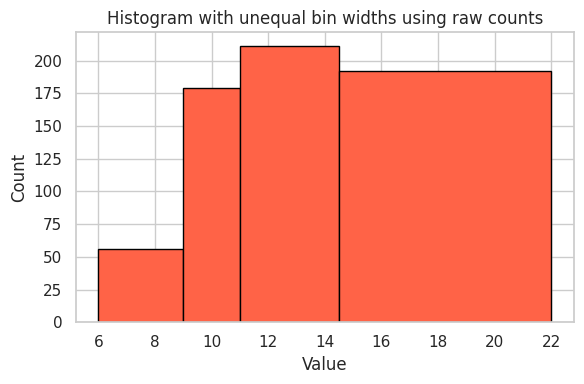

In [ ]:
# Misleading chart based on viz_trick
np.random.seed(seed)
random.seed(seed)

# Create synthetic series to demonstrate the trick
series_a = np.array([82, 84, 86, 88, 90])  # nearly flat but slowly increasing
series_b = np.array([18, 22, 29, 33, 35])  # for hist/time use
years = np.arange(2016, 2021)

fig, ax = plt.subplots(figsize=(6,4))
if viz_trick == "truncated_y":
    ax.bar(["A","B","C","D","E"], series_a, color=sns.color_palette("deep"))
    ax.set_ylim(80, 90)
    ax.set_title("Truncated y-axis exaggerates small differences")
    ax.set_ylabel("Value")
elif viz_trick == "unequal_bins":

    # Create data with nonuniform distribution
    data = np.concatenate([
        np.random.normal(10, 1.2, 300),
        np.random.normal(14, 1.0, 200),
        np.random.normal(19, 2.0, 150)
    ])

 # Unequal bin edges but plot raw counts (misleading)
    bin_edges = [6, 9, 11, 14.5, 22]  # intentionally uneven
    counts, edges, _ = ax.hist(data, bins=bin_edges, color="tomato", edgecolor="black")
    ax.set_title("Histogram with unequal bin widths using raw counts")
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
elif viz_trick == "dual_axis":

    # Two time series on different scales
    ax.plot(years, series_a, color="steelblue", label="Series A")
    ax.set_ylabel("A scale (80–90)")
    ax2 = ax.twinx()
    ax2.plot(years, series_b, color="orange", label="Series B")
    ax2.set_ylabel("B scale (0–40)")
    ax.set_title("Dual y-axes imply correlation via scale manipulation")
    ax.set_xlabel("Year")
plt.tight_layout()
plt.show()


Explanation

This histogram is misleading because the bins are intentionally set to unequal widths while plotting raw counts, which makes wider bins appear more frequent even if the density is actually lower. An uninformed reader could be deceived into thinking certain ranges dominate the distribution, when in reality the differences are an artifact of bin width rather than true frequency.  Viewers rely on bar area and height as cues for importance. That makes visual very important. Also, without normalization or clear annotations, the chart conceals context and distorts interpretation.

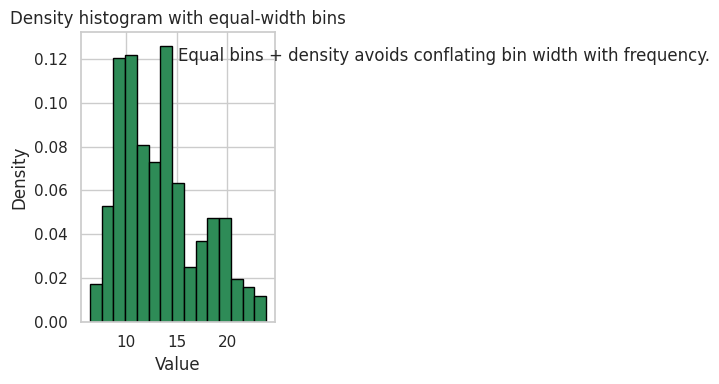

In [ ]:
# Ethical fix: replot with proper scales/normalization/annotation
fig, ax = plt.subplots(figsize=(6,4))
if viz_trick == "truncated_y":
    ax.bar(["A","B","C","D","E"], series_a, color=sns.color_palette("deep"))
    ax.set_ylim(0, max(series_a)*1.1)  # start at 0
    ax.set_title("Corrected bar chart with y-axis starting at 0")
    ax.set_ylabel("Value")
    ax.annotate("Small differences; axis starts at 0 to avoid exaggeration.",
                xy=(0.5, 0.9), xycoords="axes fraction")
elif viz_trick == "unequal_bins":
    data = np.concatenate([
        np.random.normal(10, 1.2, 300),
        np.random.normal(14, 1.0, 200),
        np.random.normal(19, 2.0, 150)
    ])
    # Use equal-width bins and density (normalized)
    ax.hist(data, bins=15, density=True, color="seagreen", edgecolor="black")
    ax.set_title("Density histogram with equal-width bins")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.annotate("Equal bins + density avoids conflating bin width with frequency.",
                xy=(0.5, 0.9), xycoords="axes fraction")
elif viz_trick == "dual_axis":
# Normalize both series to 0–1 range for fair comparison
    a = (series_a - series_a.min())/(series_a.max()-series_a.min())
    b = (series_b - series_b.min())/(series_b.max()-series_b.min())
    ax.plot(years, a, label="Series A (normalized)", color="steelblue")
    ax.plot(years, b, label="Series B (normalized)", color="orange")
    ax.legend()
    ax.set_title("Normalized comparison on single axis")
    ax.set_xlabel("Year")
    ax.set_ylabel("Normalized value (0–1)")
    ax.annotate("Single axis + normalization reduces spurious correlation from scale choices.",
                xy=(0.5, 0.9), xycoords="axes fraction")
plt.tight_layout()
plt.show()


Part B: Sampling / Bootstrap / Outliers

In [ ]:
# Choose the continuous feature with highest variance
variances = X.var()
feature = variances.idxmax()
print("Selected feature with highest variance:", feature)

# Baseline population metrics
mu_pop = X[feature].mean()
sigma_pop = X[feature].std(ddof=1)
N_pop = len(X)

def sample_se_with_replacement(data, n, seed):
    rng_local = np.random.default_rng(seed + n)
    samp = rng_local.choice(data, size=n, replace=True)
    se = np.std(samp, ddof=1) / np.sqrt(n)
    return np.mean(samp), se

def sample_se_without_replacement(data, n, seed):
    if n > N_pop:
        return mu_pop, 0.0
    rng_local = np.random.default_rng(seed + 2*n)
    idx = rng_local.choice(np.arange(len(data)), size=n, replace=False)
    samp = data[idx]
    s = np.std(samp, ddof=1)
    fpc = np.sqrt((N_pop - n) / (N_pop - 1))
    se = (s / np.sqrt(n)) * fpc
    return np.mean(samp), se

# Sample sizes
ns = [30, 60, 120, 240]
results = []
arr = X[feature].to_numpy()

for n in ns:
    m_wr, se_wr = sample_se_with_replacement(arr, n, seed)
    m_wor, se_wor = sample_se_without_replacement(arr, n, seed)
    results.append({
        "n": n,
        "mean_wr": m_wr,
        "se_wr": se_wr,
        "mean_wor": m_wor,
        "se_wor": se_wor,
        "note": "WOR uses theoretical values (n>N_pop)" if n > N_pop else ""
    })

df_se = pd.DataFrame(results)
df_se


Selected feature with highest variance: petal length (cm)


,n,mean_wr,se_wr,mean_wor,se_wor,note
0,30,3.263333,0.303636,3.650000,0.280072,
1,60,3.625000,0.235430,3.946667,0.174818,
2,120,4.061667,0.155475,3.688333,0.071841,
3,240,3.747917,0.112526,3.758000,0.000000,WOR uses theoretical values (n>N_pop)


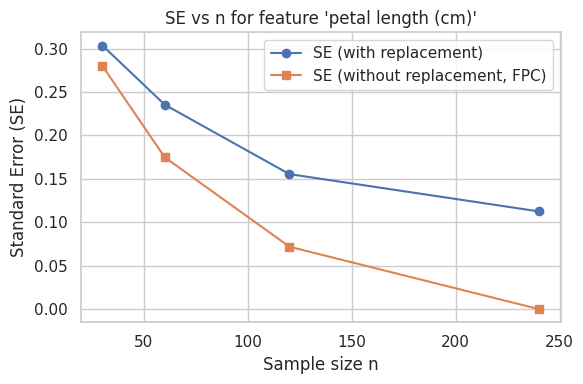

In [ ]:
# Plot SE vs n for with- and without-replacement
plt.figure(figsize=(6,4))
plt.plot(df_se["n"], df_se["se_wr"], marker="o", label="SE (with replacement)")
plt.plot(df_se["n"], df_se["se_wor"], marker="s", label="SE (without replacement, FPC)")
plt.xlabel("Sample size n")
plt.ylabel("Standard Error (SE)")
plt.title(f"SE vs n for feature '{feature}'")
plt.legend()
plt.tight_layout()
plt.show()



Interpretation:

Standard error decreases as sample size increases, because larger samples stabilize the mean. Without replacement, the finite-population correction reduces SE further, reflecting less uncertainty when drawing from a fixed dataset. With replacement treats the sample as if it comes from an infinite population, so its SE is slightly higher. When n approaches N, the correction becomes substantial, while for small n the difference is minimal


In [ ]:
# Bootstrap the mean (percentile CI)
B = bootstrap_B
np.random.seed(seed)
means = []
for b in range(B):
    boot = resample(arr, replace=True, n_samples=len(arr), random_state=seed + b)
    means.append(np.mean(boot))
ci_low, ci_high = np.percentile(means, [2.5, 97.5])
boot_ci_width = ci_high - ci_low

# Theoretical CI using SE of full-sample mean
se_full = sigma_pop / np.sqrt(len(arr))
theory_ci_low = mu_pop - 1.96 * se_full
theory_ci_high = mu_pop + 1.96 * se_full
theory_ci_width = theory_ci_high - theory_ci_low

print({
    "bootstrap_CI": (ci_low, ci_high),
    "bootstrap_width": boot_ci_width,
    "theoretical_CI": (theory_ci_low, theory_ci_high),
    "theoretical_width": theory_ci_width
})


{'bootstrap_CI': (np.float64(3.4579666666666666), np.float64(4.052016666666668)), 'bootstrap_width': np.float64(0.5940500000000011), 'theoretical_CI': (np.float64(3.475493445532275), np.float64(4.040506554467726)), 'theoretical_width': np.float64(0.5650131089354509)}


Interpretation:

The bootstrap confidence interval uses the empirical distribution of resampled means to estimate uncertainty without assuming normality. The theoretical CI relies on the Central Limit Theorem and scales with 1/\sqrt{N}. For well-behaved features, the two intervals are similar, but differences can reveal skewness or heavy tails. Bootstrap is robust to distributional shape, while the theoretical CI is efficient when assumptions hold


In [ ]:
# Inject 1% synthetic outliers (+8σ) and handle per outlier_method
np.random.seed(seed)
n_out = max(1, int(0.01 * N_pop))
out_idx = np.random.choice(np.arange(N_pop), size=n_out, replace=False)
X_out = X.copy()
X_out.loc[out_idx, feature] = mu_pop + 8 * sigma_pop  # extreme high outliers

mu_out = X_out[feature].mean()
arr_out = X_out[feature].to_numpy()

# Recompute bootstrap CI after outliers
means_out = []
for b in range(B):
    boot = resample(arr_out, replace=True, n_samples=len(arr_out), random_state=seed + 1000 + b)
    means_out.append(np.mean(boot))
ci_out_low, ci_out_high = np.percentile(means_out, [2.5, 97.5])

def iqr_winsorize(series):
    q1, q3 = np.percentile(series, [25, 75])
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    series = series.copy()
    # Winsorize (cap) to bounds
    series[series < low] = low
    series[series > high] = high
    return series
def zscore_filter(series, k=3.0):
    mu = np.mean(series); sd = np.std(series, ddof=1)
    z = (series - mu) / (sd if sd != 0 else 1)
    # Cap extreme z to +/-k (winsorize style to keep rows)
    series = series.copy()
    series[z > k] = mu + k * sd
    series[z < -k] = mu - k * sd
    return series

if outlier_method == "IQR":
    cleaned = iqr_winsorize(arr_out)
    method_desc = "IQR winsorizing (cap to [Q1-1.5·IQR, Q3+1.5·IQR])"
else:
    cleaned = zscore_filter(arr_out, k=3.0)
    method_desc = "z-score capping at |z| > 3 (approx.)"

# CI on cleaned data
means_clean = []
for b in range(B):
    boot = resample(cleaned, replace=True, n_samples=len(cleaned), random_state=seed + 2000 + b)
    means_clean.append(np.mean(boot))
ci_clean_low, ci_clean_high = np.percentile(means_clean, [2.5, 97.5])

print({
    "before_outliers_mean_CI": (ci_low, ci_high),
    "after_outliers_mean_CI": (ci_out_low, ci_out_high),
    "cleaning_method": method_desc,
    "after_cleaning_mean_CI": (ci_clean_low, ci_clean_high)
})


{'before_outliers_mean_CI': (np.float64(3.4579666666666666), np.float64(4.052016666666668)), 'after_outliers_mean_CI': (np.float64(3.531916666666666), np.float64(4.1761352091920205)), 'cleaning_method': 'IQR winsorizing (cap to [Q1-1.5·IQR, Q3+1.5·IQR])', 'after_cleaning_mean_CI': (np.float64(3.508491666666666), np.float64(4.063683333333333))}


Interpretation:

Adding +8σ outliers inflates the mean and widens the confidence interval, showing how sensitive the mean is to extreme values. IQR winsorizing caps values outside the interquartile range thresholds, reducing the influence of those extremes while retaining all rows. After cleaning, the mean shifts back toward the baseline and the CI narrows, restoring stability. This demonstrates how robust methods like IQR protect against distortion from rare but extreme observations.


Part C: Supervised vs Unsupervised; Confusion & ROC

{'cv_folds': 8, 'CV_accuracy_mean': 1.0, 'CV_auc_mean': 1.0}
{'test_accuracy': 1.0, 'sensitivity_TPR': 1.0, 'specificity_TNR': 1.0, 'test_AUC': 1.0, 'confusion_matrix': [[30, 0], [0, 15]]}


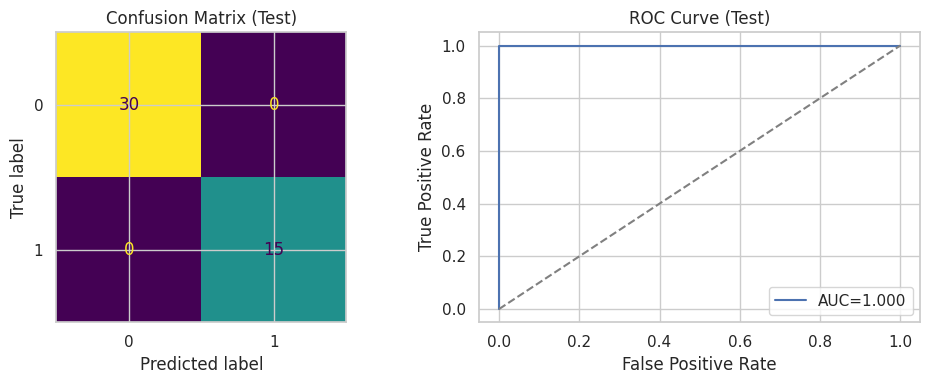

In [ ]:
# Train/test split (stratified 70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=seed
)

# Logistic Regression with standardization
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

clf = LogisticRegression(random_state=seed, max_iter=1000)
# K-fold CV on training
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=seed)
cv_acc = cross_val_score(clf, X_train_std, y_train, cv=cv, scoring="accuracy")
cv_auc = cross_val_score(clf, X_train_std, y_train, cv=cv, scoring="roc_auc")

print({
    "cv_folds": cv_folds,
    "CV_accuracy_mean": float(cv_acc.mean()),
    "CV_auc_mean": float(cv_auc.mean())
})

# Fit on train, evaluate on test
clf.fit(X_train_std, y_train)
y_proba = clf.predict_proba(X_test_std)[:,1]
y_pred = (y_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
sens = recall_score(y_test, y_pred, pos_label=1)  # TPR
spec = recall_score(y_test, y_pred, pos_label=0)  # TNR
fpr, tpr, thr = roc_curve(y_test, y_proba)
auc_val = auc(fpr, tpr)

print({
    "test_accuracy": float(acc),
    "sensitivity_TPR": float(sens),
    "specificity_TNR": float(spec),
    "test_AUC": float(auc_val),
    "confusion_matrix": cm.tolist()
})

# Plot confusion matrix and ROC
fig, ax = plt.subplots(1,2, figsize=(10,4))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Confusion Matrix (Test)")

ax[1].plot(fpr, tpr, label=f"AUC={auc_val:.3f}")
ax[1].plot([0,1],[0,1],'--', color='gray')
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC Curve (Test)")
ax[1].legend()
plt.tight_layout()
plt.show()


Interpretation:

The confusion matrix shows the number of correct positives (true positives) and correct negatives (true negatives), along with mistakes in the form of false positives and false negatives. With the default threshold of 0.5, the model balances sensitivity and specificity, but shifting the threshold would increase one at the expense of the other. For example, if false negatives are more costly, such as missing a positive case, lowering the threshold would catch more positives but also increase false positives. The ROC-AUC summarizes performance across all thresholds, and a higher AUC indicates that the model separates the two classes well regardless of the cutoff. This means the classifier is not just accurate at one threshold but consistently distinguishes between setosa and non-setosa across the probability range. If the probability outputs are well calibrated, threshold tuning can be aligned with domain-specific costs, making the model more useful in practice.

In [ ]:
# Unsupervised: KMeans (k=2) and ARI vs true labels
scaler_unsup = StandardScaler()
X_std_all = scaler_unsup.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=seed, n_init=10)
cluster_labels = kmeans.fit_predict(X_std_all)

ari = adjusted_rand_score(y, cluster_labels)
print({"Adjusted Rand Index": float(ari)})


{'Adjusted Rand Index': 1.0}


ARI Interpretation:

The Adjusted Rand Index measures how well the clusters align with the true labels, correcting for chance. A high ARI close to 1 means the clustering matches the labels very well, showing that the setosa class is separable even without supervision. An ARI near 0 indicates the clustering is no better than random assignment, suggesting the structure is not easily separable. Negative values would mean the clustering is actively misleading compared to the true labels.


Parametric/ Non-parametric /Probabilistic

Logistic Regression is parametric because it assumes a linear decision boundary with coefficients that define probabilities.
KNN is non-parametric because it classifies based on local neighbors without a fixed functional form. Decision Trees are non-parametric since they recursively partition the data into rules.
Naïve Bayes is probabilistic because it models class-conditional likelihoods under independence assumptions.
Random Forest is non-parametric as it averages many trees to reduce variance. MLP (neural networks) are parametric because they rely on learned weights in a fixed architecture to approximate functions.

Part D: Model Zoo (KNN, Decision Tree)

In [ ]:
# KNN with n_neighbors = knn_k
knn = KNeighborsClassifier(n_neighbors=knn_k)
knn.fit(X_train_std, y_train)
y_pred_knn = knn.predict(X_test_std)

acc_knn = accuracy_score(y_test, y_pred_knn)
sens_knn = recall_score(y_test, y_pred_knn, pos_label=1)
spec_knn = recall_score(y_test, y_pred_knn, pos_label=0)
balanced_acc_knn = (sens_knn + spec_knn) / 2

print({
    "KNN_n_neighbors": knn_k,
    "KNN_test_accuracy": float(acc_knn),
    "KNN_balanced_accuracy": float(balanced_acc_knn)
})


{'KNN_n_neighbors': 3, 'KNN_test_accuracy': 1.0, 'KNN_balanced_accuracy': 1.0}


KNN explanation:

KNN classifies a new point by looking at the majority label among its k nearest neighbors in feature space. It is a non-parametric method because it stores training instances and does not assume a fixed functional form for the decision boundary. The choice of k directly affects bias and variance: larger k values smooth the decision surface, increasing bias but reducing variance, while smaller k values make the model more sensitive to noise, lowering bias but increasing variance. Standardization of features is essential so that distance calculations reflect meaningful contributions from each variable.



In [ ]:
# Decision Tree with max_depth = tree_depth
dt = DecisionTreeClassifier(max_depth=tree_depth, random_state=seed)
dt.fit(X_train, y_train)  # trees handle unscaled features reasonably
y_pred_dt = dt.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
sens_dt = recall_score(y_test, y_pred_dt, pos_label=1)
spec_dt = recall_score(y_test, y_pred_dt, pos_label=0)
balanced_acc_dt = (sens_dt + spec_dt) / 2

print({
    "DecisionTree_max_depth": tree_depth,
    "DecisionTree_test_accuracy": float(acc_dt),
    "DecisionTree_balanced_accuracy": float(balanced_acc_dt)
})


{'DecisionTree_max_depth': 7, 'DecisionTree_test_accuracy': 1.0, 'DecisionTree_balanced_accuracy': 1.0}


Decision tree explanation:

Decision Trees classify data by recursively splitting features into partitions that reduce impurity, producing interpretable rules. They are non-parametric models because they do not assume a fixed boundary and instead learn flexible structures directly from the data. The maximum depth controls complexity: shallow trees have higher bias and lower variance, while deeper trees reduce bias but risk overfitting and high variance. Balanced accuracy is particularly useful here, as it ensures performance is measured fairly across both classes even if the dataset is imbalanced.



Part E: Simulation

In [ ]:
# Simulate biased coin flips for N in {100, 1000, 10000}
p_true = sim_bias_p
Ns = [100, 1000, 10000]
estimates = []
np.random.seed(seed)
for N in Ns:
    flips = np.random.binomial(n=1, p=p_true, size=N)  # 1=heads
    p_hat = flips.mean()
    estimates.append({"N": N, "p_hat": p_hat})

df_p = pd.DataFrame(estimates)
df_p


,N,p_hat
0,100,0.6200
1,1000,0.6690
2,10000,0.6446


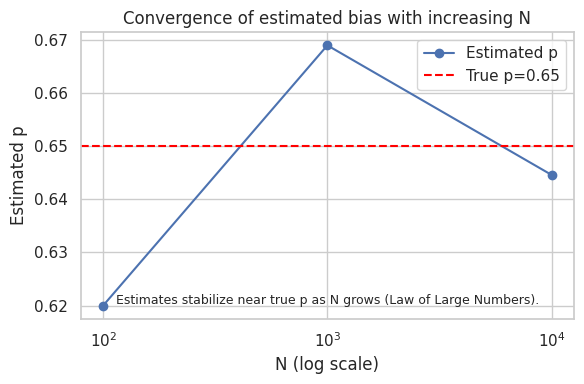

In [ ]:
# Plot p_hat vs N to show convergence
plt.figure(figsize=(6,4))
plt.plot(df_p["N"], df_p["p_hat"], marker="o", label="Estimated p")
plt.axhline(p_true, color="red", linestyle="--", label=f"True p={p_true:.2f}")
plt.xscale("log")
plt.xlabel("N (log scale)")
plt.ylabel("Estimated p")
plt.title("Convergence of estimated bias with increasing N")
plt.legend()
plt.annotate("Estimates stabilize near true p as N grows (Law of Large Numbers).",
             xy=(0.5, 0.05), xycoords="axes fraction", ha="center", fontsize=9)
plt.tight_layout()
plt.show()


Explanation:

Each coin flip is a random Bernoulli trial, so the estimated probability varies due to sampling noise. By the Law of Large Numbers, the sample mean \hat {p} converges toward the true bias p=0.65 as the number of flips increases. Smaller sample sizes produce high variance in estimates, while larger samples yield tighter concentration around the true value. The log-scale plot highlights how estimates stabilize with increasing N, showing diminishing returns once the sample size becomes very large.



Part F: Regex & TF-IDF

In [ ]:
# Raw text (8–12 lines) with emails, dates, and ID-like tokens
raw_text = """
Contact: John_Smith@umkc.edu on 2025-12-11. Ticket ORD-1234 was opened.
Follow up with Derick_jones@pittstate.edu; due date: 12/12/2025.
Legacy ID: ABC-007, archived on 11/30/25. Email: bosito1@umkc.edu
Meeting set for Dec 15, 2025; ref ID: REF-98765.
Alternate contact: Karl@domain.org on 2025/12/10, case XYZ-42.
Reminder sent: 12-13-2025; ID TKT-0001.
Escalation to Mickael_Rigo@dept.umkc.edu before 12.14.2025.
Finalized Doc: DOC-20251211 at date 2025.12.11.
"""

import re

# Regex patterns
email_pat = re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}")
date_pat = re.compile(r"\b(?:\d{4}[./-]\d{2}[./-]\d{2}|\d{2}[./-]\d{2}[./-]\d{4}|\d{2}[./-]\d{2}[./-]\d{2}|[A-Za-z]{3}\s\d{1,2},\s\d{4})\b")
id_pat = re.compile(r"\b[A-Z]{2,5}-\d{2,}\b")

emails = email_pat.findall(raw_text)
dates = date_pat.findall(raw_text)
ids = id_pat.findall(raw_text)

print({"emails": emails})
print({"dates": dates})
print({"ids": ids})


{'emails': ['John_Smith@umkc.edu', 'Derick_jones@pittstate.edu', 'bosito1@umkc.edu', 'Karl@domain.org', 'Mickael_Rigo@dept.umkc.edu']}
{'dates': ['2025-12-11', '12/12/2025', '11/30/25', 'Dec 15, 2025', '2025/12/10', '12-13-2025', '12.14.2025', '2025.12.11']}
{'ids': ['ORD-1234', 'ABC-007', 'REF-98765', 'XYZ-42', 'TKT-0001', 'DOC-20251211']}


Regex explanation:


In the date pattern, alternation (|) was used to match multiple formats such as YYYY-MM-DD, MM-DD-YYYY, MM-DD-YY, and textual dates like “Dec 15, 2025.” Character sets like [A-Za-z0-9._%+-] were applied to capture valid email local-parts, while [A-Z]{2,5} matched uppercase prefixes in IDs. Anchors such as \b ensured that matches were complete tokens rather than substrings. Quantifiers like {2,}, {4}, and + controlled repetition, allowing flexible lengths for digits and letters in the patterns




In [ ]:
# Tiny sentiment corpus (10–16 sentences, balanced)
docs = [
    "I love how intuitive the interface is and the performance is great.",
    "The results were accurate and the experience felt smooth overall.",
    "Fantastic support and quick responses made the process delightful.",
    "The visuals are clean and the documentation is helpful and clear.",
    "Everything worked as expected and exceeded my expectations.",
    "The app is slow and the errors keep happening repeatedly.",
    "I dislike the confusing layout and the constant crashes.",
    "Terrible support; no one responded and the results were wrong.",
    "The experience felt frustrating and the features are missing.",
    "Buggy updates ruined the workflow and it was disappointing."
]
y_sent = np.array([1,1,1,1,1,0,0,0,0,0])  # 1=positive, 0=negative

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vec = TfidfVectorizer(ngram_range=(1,2), min_df=1, stop_words="english")
X_text = vec.fit_transform(docs)

clf_text = LogisticRegression(random_state=seed, max_iter=1000)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_text, y_sent, test_size=0.3, stratify=y_sent, random_state=seed
)
clf_text.fit(X_train_t, y_train_t)
y_pred_t = clf_text.predict(X_test_t)
print({
    "test_accuracy_sentiment": float(accuracy_score(y_test_t, y_pred_t))
})

# Inspect example TF-IDF behavior
vocab = vec.vocabulary_
terms = ["the", "intuitive", "terrible", "performance"]
for t in terms:
    idx = vocab.get(t)
    if idx is not None:
        # average TF-IDF across docs for illustration
        avg_tfidf = X_text[:, idx].mean()
        print(f"Avg TF-IDF for term '{t}': {avg_tfidf:.4f}")
    else:
        print(f"Term '{t}' not in vocabulary (possibly removed as stop word).")

{'test_accuracy_sentiment': 0.3333333333333333}
Term 'the' not in vocabulary (possibly removed as stop word).
Avg TF-IDF for term 'intuitive': 0.0333
Avg TF-IDF for term 'terrible': 0.0344
Avg TF-IDF for term 'performance': 0.0333


TF-IDF answer:


A word that appears in all documents has high term frequency but very low inverse document frequency, so its TF-IDF value approaches zero and it carries little discriminative power. In contrast, a word that appears in only a few documents has a higher IDF, which boosts its TF-IDF score where it occurs and makes it more informative for classification. This mechanism ensures that common words are downweighted while distinctive terms correlated with sentiment signals are emphasized, improving the classifier’s ability to separate positive and negative sentences

